# Cell-Cell Communication (CCC)

Author: Franziska Niemeyer

Modified from: Francesca Drummer

Contact: franziska.niemeyer@helsinki.fi

**Topics in this notebook:**
1. LIANA+ for CCC in ST data
2. Learning relationships with MistY
3. Spatially-aware CCC

Cells coordinate tissue function through many communication channels, including secreted factors (cytokines, growth factors), contact-dependent signaling (e.g., Notch), cell–cell/ECM adhesion and mechanotransduction, gap junction exchange of ions/metabolites, and extracellular vesicles carrying proteins, lipids, and nucleic acids.  ￼

With RNA-seq and spatial transcriptomics, we mostly **infer potential communication** — especially autocrine and paracrine signaling by soluble factors — by looking for **coordinated expression of ligands, receptors**, and (optionally) downstream transcriptional responses. Tools like NicheNet go beyond co-expression by linking ligands to predicted target-gene programs in receiver cells, but this is still inference rather than direct observation of signaling events.  ￼

Direct evidence for CCC often requires other modalities, such as protein measurements (e.g., antibody-derived tags in CITE-seq), spatial proteomics/imaging (e.g., imaging mass cytometry), or interaction/activation assays (e.g., in situ proximity-based methods, phospho-readouts), which capture receptor presence, proximity, and pathway activation more directly than mRNA alone.

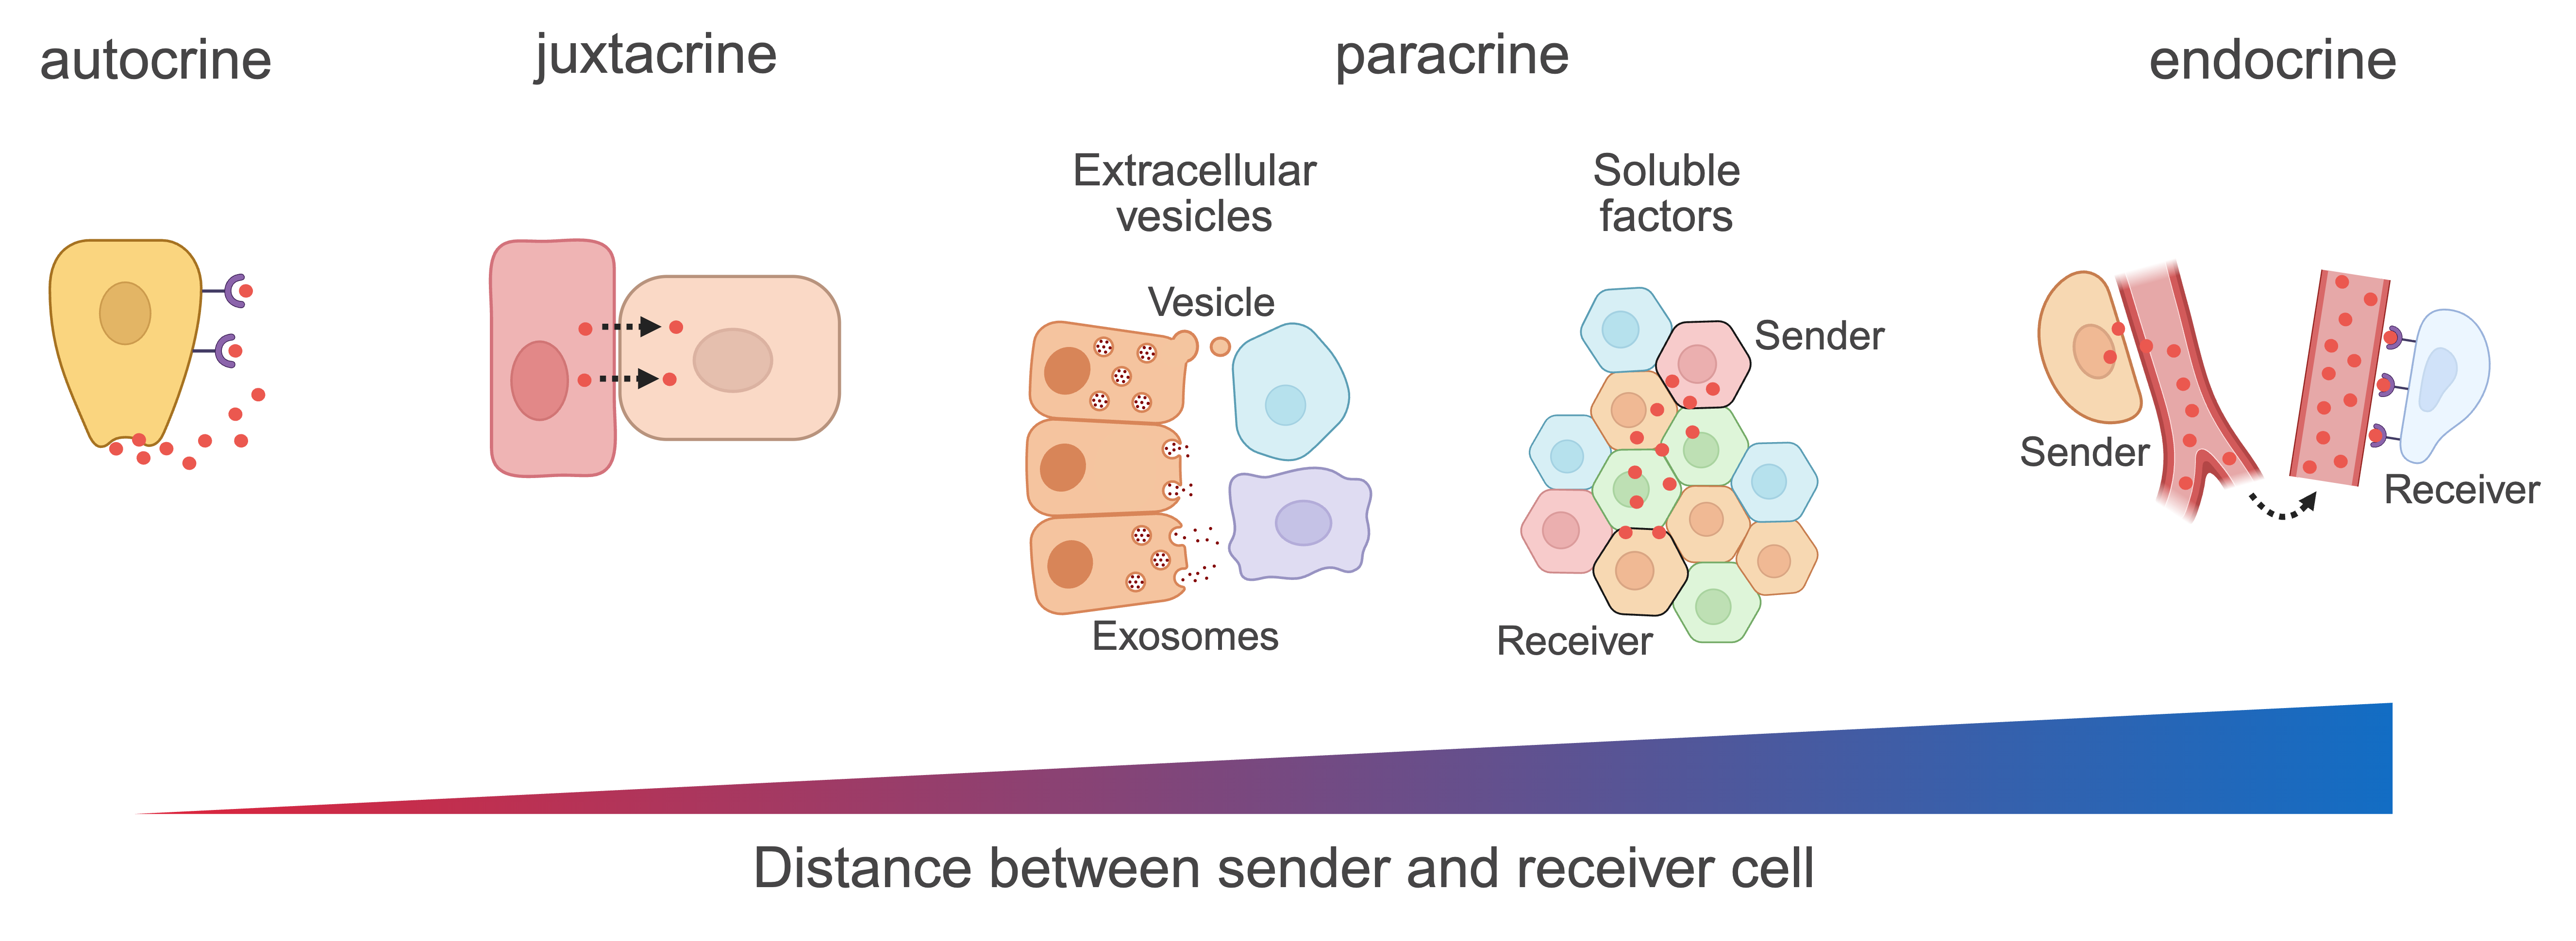

In [1]:
import numpy as np
# import squidpy as sq
import scanpy as sc
import liana as li
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from matplotlib.colors import ListedColormap
from scipy.sparse import issparse, csr_matrix
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean

In [16]:
path = "/home/jovyan/shared/day-04/data/Xenium_mouse_AD/"
adata = sc.read_h5ad(Path(path, 'adata_with_spatial_domains.h5ad'))

LIANA+ expects our count data to be log-normalized, which is the case here already.

In [17]:
print(adata.X[:5,:5])

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 3 stored elements and shape (5, 5)>
  Coords	Values
  (1, 0)	0.6931471824645996
  (4, 2)	0.6931471824645996
  (4, 3)	1.3862943649291992


## Introduction to LIANA+

[LIANA+](https://liana-py.readthedocs.io/en/latest/notebooks/basic_usage.html) is a toolbox in Python for various dissociated, multimodal and spatially informed cell-cell communication tools [Dimitrov et al., 2024].

First, we will check which methods are implemented in LIANA+.
Each method relies on different assumptions and returns a different ligand-receptor score.
Usually, each method provides one score for the strength of the interaction (`magnitude`) and one score reflecting the `specifivity` of an interaction to a pair of cell identities.

In [17]:
li.mt.show_methods()

Method Name Magnitude Score Specificity Score  \
0        CellPhoneDB        lr_means   cellphone_pvals   
0         Connectome       expr_prod     scaled_weight   
0             log2FC            None          lr_logfc   
0              NATMI       expr_prod       spec_weight   
0  SingleCellSignalR         lrscore              None   
0     Rank_Aggregate  magnitude_rank  specificity_rank   
0     Geometric Mean       lr_gmeans       gmean_pvals   
0          scSeqComm     inter_score              None   
0           CellChat        lr_probs    cellchat_pvals   

                                           Reference  
0  Efremova, M., Vento-Tormo, M., Teichmann, S.A....  
0  Raredon, M.S.B., Yang, J., Garritano, J., Wang...  
0  Dimitrov, D., Türei, D., Garrido-Rodriguez, M....  
0  Hou, R., Denisenko, E., Ong, H.T., Ramilowski,...  
0  Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ...  
0  Dimitrov, D., Türei, D., Garrido-Rodriguez, M....  
0  CellPhoneDBv2's permutation approach applied t...  
0  Baruzzo, G., Cesaro, G., Di Camillo, B. 2022. ...  
0  Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha...

Most cell-cell communication (CCC) tools identify ligand-receptor (LR) interaction. For this they rely on a extracting LR pairs from databases. There are diverse databases but LIANA+ has a consensus database that uses LR that are overlapping across databases.

First, we need to ensure that there are LR-pairs present in the data to be detected for communication.

In [26]:
print(li.resource.show_resources())
resource_name = "mouseconsensus"  # Replace with the desired resource name if needed
lr_pairs = li.resource.select_resource(resource_name)
lr_pairs

['baccin2019', 'cellcall', 'cellchatdb', 'cellinker', 'cellphonedb', 'celltalkdb', 'connectomedb2020', 'consensus', 'embrace', 'guide2pharma', 'hpmr', 'icellnet', 'italk', 'kirouac2010', 'lrdb', 'mouseconsensus', 'ramilowski2015']


ligand     receptor
31371       Dll1       Notch1
31372       Dll1       Notch2
31373       Dll1       Notch4
31374       Dll1       Notch3
31375       Nrg2  Erbb2_Erbb3
...          ...          ...
35355  Serpina1a         Lrp1
35356  Serpina1b         Lrp1
35357  Serpina1c         Lrp1
35358  Serpina1d         Lrp1
35359  Serpina1e         Lrp1

[3989 rows x 2 columns]

In [27]:
def lr_pairs_in_adata(adata):
    genes_in_dataset = set(adata.var_names)  # Unique transcript names

    # Filter the ligand-receptor pairs for those present in your dataset
    filtered_lr_pairs = lr_pairs[
        lr_pairs['ligand'].isin(genes_in_dataset) & lr_pairs['receptor'].isin(genes_in_dataset)
    ]
    return filtered_lr_pairs

In [28]:
filtered_lr_pairs = lr_pairs_in_adata(adata)

<div style="
  padding: 12px 14px;
  border-left: 5px solid #1aa6a6;
  background: rgba(26,166,166,0.08);
  border-radius: 10px;
  margin: 10px 0;
">
  <div style="font-weight: 700; margin-bottom: 6px;">👾 Task</div>

<p>How many ligand-receptor paris are in the data?
</div>

In [29]:
#| hide-input: true
num_lr_pairs = len(filtered_lr_pairs)
print(f"Number of ligand-receptor pairs present in the dataset: {num_lr_pairs}")

Number of ligand-receptor pairs present in the dataset: 16


We will only use a subset of the dataset here.

In [32]:
sub_adata = adata[(adata.obs['time'] == '5_7') & (adata.obs['condition'] == 'TgCRND8')]
print(f"Number of cells in sub_adata: {sub_adata.n_obs}")
print(f"Number of genes in sub_adata: {sub_adata.n_vars}")

Number of cells in sub_adata: 58621
Number of genes in sub_adata: 347


### CellPhoneDB

First, we will run CellPhoneDB as if we did not have any spatial information.

In [38]:
cellphonedb(sub_adata,
            groupby='cell_types',
            resource_name='mouseconsensus', # NOTE by default the resource uses HUMAN gene symbols
            expr_prop=0.1,
            verbose=True,
            use_raw=False,
            key_added='cpdb_res')

Using resource `mouseconsensus`.
Using `.X`!
/opt/conda/envs/p16_ccc/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:88: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
0.94 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 58621 samples and 22 features


100%|██████████| 1000/1000 [00:05<00:00, 188.57it/s]
/opt/conda/envs/p16_ccc/lib/python3.12/site-packages/liana/method/sc/_Method.py:274: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


In [39]:
sub_adata.uns['cpdb_res'].head()

ligand ligand_complex  ligand_means  ligand_props receptor  \
45   Apoe           Apoe      2.489744      0.988430    Sorl1   
1    Apoe           Apoe      2.489744      0.988430    Sorl1   
60   Apoe           Apoe      2.489744      0.988430    Sorl1   
56   Apoe           Apoe      2.008916      0.979358    Sorl1   
75   Apoe           Apoe      2.489744      0.988430    Sorl1   

   receptor_complex  receptor_means  receptor_props      source  \
45            Sorl1        0.894947        0.749796  Astrocytes   
1             Sorl1        0.519409        0.533792  Astrocytes   
60            Sorl1        0.908217        0.726773  Astrocytes   
56            Sorl1        0.894947        0.749796         OPC   
75            Sorl1        0.369849        0.397936  Astrocytes   

                 target  lr_means  cellphone_pvals  
45   Inhibitory neurons  1.665341              0.0  
1            Astrocytes  1.498878              0.0  
60  Mixed Neurons/Oligo  1.490662              0.0  
56   Inhibitory neurons  1.435852              0.0  
75                  OPC  1.368097              0.0

<div style="
  padding: 12px 14px;
  border-left: 5px solid #7E57C2;
  background: rgba(126,87,194,0.08);
  border-radius: 10px;
  margin: 10px 0;
">
  <div style="font-weight: 700; margin-bottom: 6px;">🧠 Interpretation</div>
<ul>
    <li>Source and target columns represent the source/sender and target/receiver cell identity for each interaction, respectively.</li>
    <li>*_props: represents the proportion of cells that express the entity.</li>
    <li>*_means: entity expression mean per cell type.</li>
    <li>lr_means: mean ligand-receptor expression, as a measure of ligand-receptor interaction magnitude</li>
</ul>
</div>

<div style="
  padding: 12px 14px;
  border-left: 5px solid #1aa6a6;
  background: rgba(26,166,166,0.08);
  border-radius: 10px;
  margin: 10px 0;
">
  <div style="font-weight: 700; margin-bottom: 6px;">👾 Task</div>
Plot the top 3 interacting complexes.
</div>

/tmp/ipykernel_1711/4157262916.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.


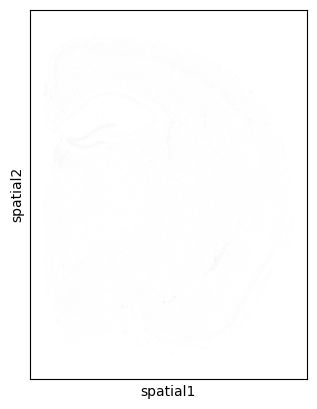

In [48]:
#| hide-input: true
sq.pl.spatial_scatter(sub_adata, 
                      color=[],
                      layer = 'median_ft',
                      shape=None)

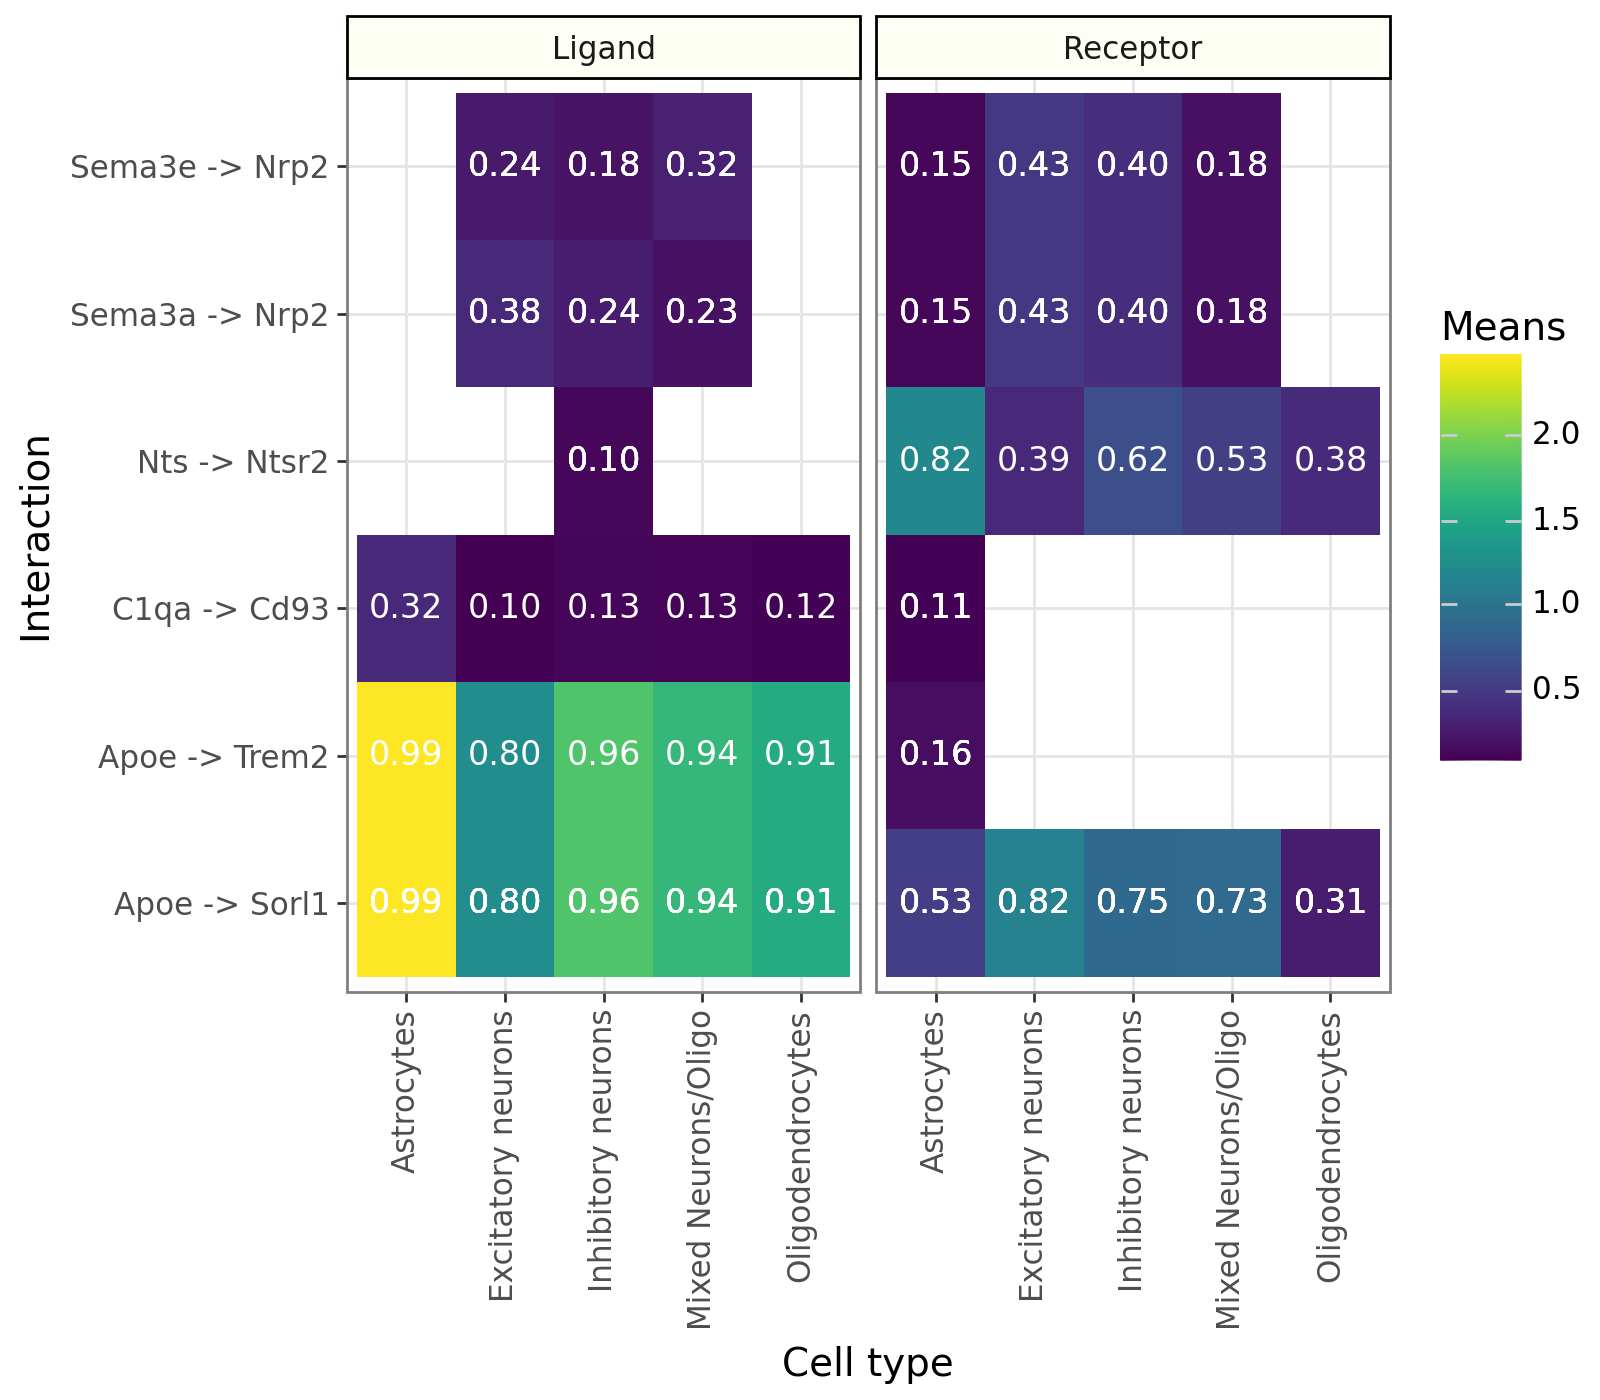

In [52]:
my_plot = li.pl.tileplot(adata = sub_adata,
                         fill='means',
                         label='props',
                         label_fun=lambda x: f'{x:.2f}',
                         orderby='cellphone_pvals',
                         orderby_ascending=True,
                         source_labels=['Astrocytes', 'Oligodendrocytes', 'Mixed Neurons/Oligo', 'Inhibitory neurons', 'Excitatory neurons'],
                         target_labels=['Astrocytes', 'Oligodendrocytes', 'Mixed Neurons/Oligo', 'Inhibitory neurons', 'Excitatory neurons'],
                         uns_key='cpdb_res', # NOTE: default is 'liana_res'
                         source_title='Ligand',
                         target_title='Receptor',
                         figure_size=(8, 7)
                         )
my_plot

<div style="
  padding: 12px 14px;
  border-left: 5px solid #7E57C2;
  background: rgba(126,87,194,0.08);
  border-radius: 10px;
  margin: 10px 0;
">
  <div style="font-weight: 700; margin-bottom: 6px;">🪞 Reflection</div>
  <div>
    What can we observe if we do not consider spatial information? Why could this be problematic?
  </div>

  <details style="
    margin-top: 10px;
    padding: 8px 10px;
    background: rgba(0,0,0,0.05);
    border-radius: 8px;
  ">
    <summary style="cursor: pointer; font-weight: 600;">
      🔎 Click to reveal answer
    </summary>
    <div style="margin-top: 8px;">
      We might infer interactions between cell types that are spatially too far away from each other to be plausable if we do not take spatial information into account. We can do better with the spatial context we actually have!
    </div>
  </details>
</div>

<div style="
  padding: 12px 14px;
  border-left: 5px solid #1aa6a6;
  background: rgba(26,166,166,0.08);
  border-radius: 10px;
  margin: 10px 0;
">
  <div style="font-weight: 700; margin-bottom: 6px;">👾 Task</div>
    <div>
        Plot the ligand and receptor genes spatially. Are they 
    </div>
</div>

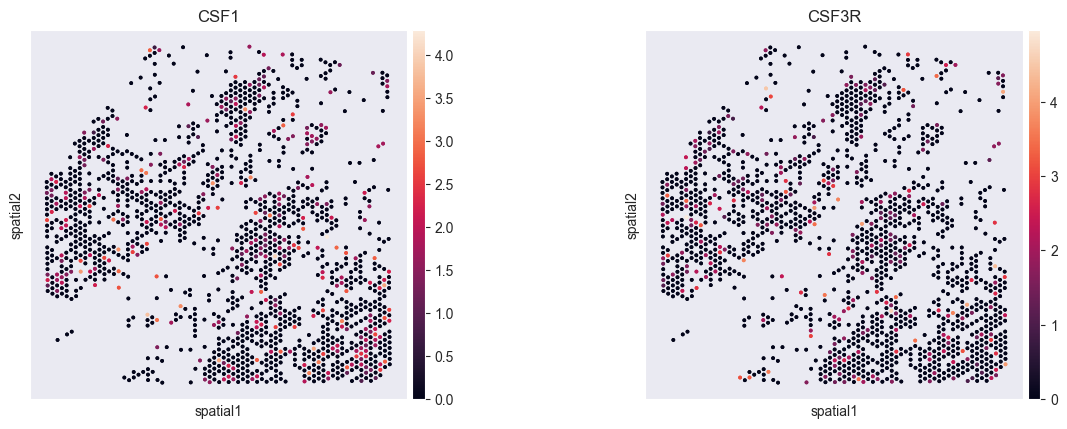

In [155]:
#| hide-input: true
sq.pl.spatial_scatter(sub_adata,
                      color=["Apoe", "Sorl1"],
                      size=1.5,
                      shape=None
                      )

In [ ]:
#| hide-input: true
sq.pl.spatial_scatter(sub_adata,
                      color=["Apoe", "Trem2"],
                      size=1.5,
                      shape=None
                      )

In [ ]:
#| hide-input: true
sq.pl.spatial_scatter(sub_adata,
                      color=["C1qa", "Cd93"],
                      size=1.5,
                      shape=None
                      )

To overcome this issue we will cover two possible approaches to integrate spatial information into non-spatially aware CCC tools, like ``CellPhoneDB``.

1. Restrict the input to **spatially variable genes**.
2. Post-processing of interactions using **spatial proximity**, i.e. niche information.

## Spatially-variable gene selection

We can use the Moran's $I$ score as a measure of spatial autocorrelation - as we learned in the Spatial Statistics practical - to identify spatially variable genes.

In [ ]:
sq.gr.spatial_neighbors(sub_adata, n_neighs=30, coord_type="generic", key_added='neighs_based_spatial')

In [ ]:
sq.gr.interaction_matrix(sub_adata, cluster_key='celltype', connectivity_key='neighs_based_spatial', normalized=True)
sq.pl.interaction_matrix(sub_adata, cluster_key='celltype') 

In [ ]:
sq.gr.spatial_autocorr(sub_adata, connectivity_key="neighs_based_spatial_connectivities", mode="moran", n_perms=50, genes=sub_adata.var_names)

In [137]:
sub_adata.uns["moranI"].head()

I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
MYL2   0.668033        0.0  0.000016         0.0  0.019608  0.000180   
MYH6   0.666850        0.0  0.000016         0.0  0.019608  0.000156   
NPPB   0.651278        0.0  0.000016         0.0  0.019608  0.000164   
ACTC1  0.643078        0.0  0.000016         0.0  0.019608  0.000153   
ACTA1  0.641883        0.0  0.000016         0.0  0.019608  0.000154   

       pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
MYL2                0.0                0.0          0.04865  
MYH6                0.0                0.0          0.04865  
NPPB                0.0                0.0          0.04865  
ACTC1               0.0                0.0          0.04865  
ACTA1               0.0                0.0          0.04865

<div style="
  padding: 12px 14px;
  border-left: 5px solid #1aa6a6;
  background: rgba(26,166,166,0.08);
  border-radius: 10px;
  margin: 10px 0;
">
  <div style="font-weight: 700; margin-bottom: 6px;">👾 Task</div>
    <div>
        Plot the 3 genes with the highest Moran's $I$ spatially.
    </div>
</div>

In [ ]:
#| hide-input: true
sq.pl.spatial_scatter(sub_adata,
                      color=[],
                      layer='median_ft',
                      shape=None)

Let's take a look at how the values for Moran's I are distributed across the genes.

/var/folders/ml/ckydwkhn4zjbmx3s2k4ss7fckdkbsq/T/ipykernel_46800/466164531.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


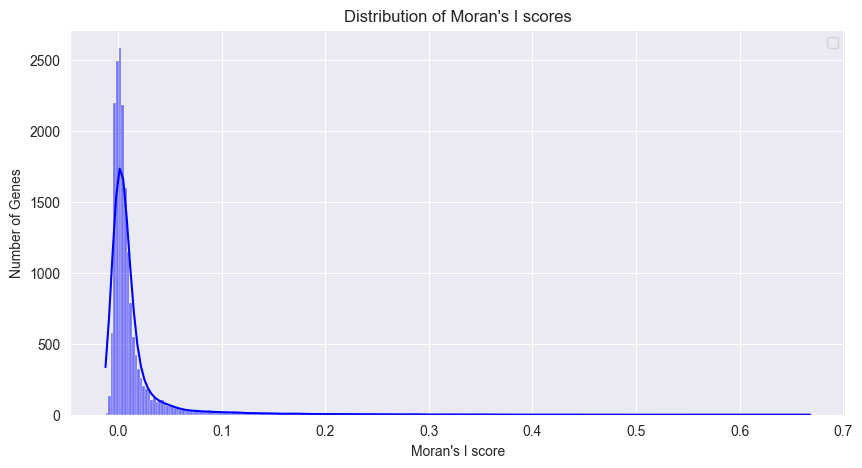

In [139]:
plt.figure(figsize=(10, 5))
sns.histplot(sub_adata.uns["moranI"]["I"], color="blue", kde=True)
plt.xlabel("Moran's I score")
plt.ylabel("Number of Genes")
plt.title("Distribution of Moran's I scores")
plt.legend()
plt.show()

Subset data to only spatially variable genes and check that there are still LR pairs present.

In [140]:
adata_svg = adata[:, adata.uns["moranI"]['I'] > 0.03].copy()
adata_svg

AnnData object with n_obs × n_vars = 4113 × 1951
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'rps', 'mrp', 'rpl', 'duplicated'
    uns: 'spatial', 'log1p', 'neighs_based_spatial_neighbors', 'moranI'
    obsm: 'compositions', 'mt', 'spatial'
    layers: 'counts', 'log-transformed'
    obsp: 'neighs_based_spatial_connectivities', 'neighs_based_spatial_distances'

In [141]:
lr_pairs_in_adata(sub_adata_svg)

Number of ligand-receptor pairs present in the dataset: 3


In [142]:
sub_adata.uns['spatial']

{'Visium_19_CK297': {'images': {'hires': array([[[0.99607843, 0.99607843, 0.99607843],
           [0.99607843, 0.99607843, 0.99607843],
           [0.99607843, 0.99607843, 0.99607843],
           ...,
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ]],
   
          [[0.99607843, 0.99607843, 0.99607843],
           [0.99607843, 0.99607843, 0.99607843],
           [0.99607843, 0.99607843, 0.99607843],
           ...,
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ]],
   
          [[1.        , 1.        , 0.99607843],
           [0.99607843, 0.99607843, 0.99607843],
           [0.99607843, 0.99607843, 0.99607843],
           ...,
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ]],
   
          ...,
  

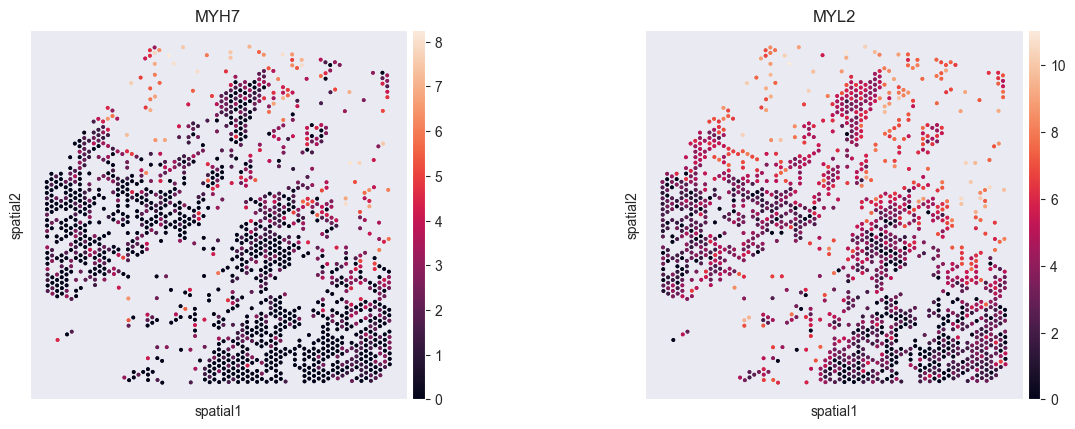

In [144]:
sq.pl.spatial_scatter(sub_adata,
                      library_id='Visium_19_CK297',
                      color=["MYH7", "MYL2"],
                      size=1.5,
                      shape=None
                      )

## MISTY

MISTy is a framework that helps understand how different features, such as genes or cell types interact with each other in space.
For this MISTy uses so called *views*, each describing a different spatial context.

In [156]:
import decoupler as dc
import plotnine as p9

# Import Helper functions needed to create MISTy objects
from liana.method import MistyData, genericMistyData, lrMistyData

#I mport predefined single view models
from liana.method.sp import RandomForestModel, LinearModel, RobustLinearModel

/Users/niemeyfr/Library/Caches/pypoetry/virtualenvs/practical-10-EMFiay-A-py3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Estimate pathway activities

Before we run MISTy, let’s estimate pathway activities as a way to make the data a bit more interpretable. We will use [decoupler-py](https://academic.oup.com/bioinformaticsadvances/article/2/1/vbac016/6544613) with pathway genesets from [PROGENy](https://www.nature.com/articles/s41467-017-02391-6). See [this](https://decoupler-py.readthedocs.io/en/latest/notebooks/spatial.html) tutorial for details.

In [157]:
progeny = dc.op.progeny(organism="human")
progeny

source   target     weight          padj
0      Androgen  TMPRSS2  11.490631  2.384806e-47
1      Androgen   NKX3-1  10.622551  2.205102e-44
2      Androgen   MBOAT2  10.472733  4.632376e-44
3      Androgen     KLK2  10.176186  1.944410e-40
4      Androgen     SARG  11.386852  2.790210e-40
...         ...      ...        ...           ...
62416       p53    ENPP2   2.771405  4.993215e-02
62417       p53   ARRDC4   3.494328  4.996747e-02
62418       p53    MYO1B  -1.148057  4.997905e-02
62419       p53     CTSC  -1.784693  4.998864e-02
62420       p53    NAA50  -1.435013  4.998884e-02

[62421 rows x 4 columns]

In [158]:
dc.mt.ulm(data=adata, net=progeny)

In [161]:
score = dc.pp.get_obsm(
    adata=adata,
    key="score_ulm",
)
score

AnnData object with n_obs × n_vars = 4113 × 14
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
    uns: 'spatial', 'log1p', 'neighs_based_spatial_neighbors', 'moranI'
    obsm: 'compositions', 'mt', 'spatial', 'score_ulm', 'padj_ulm'

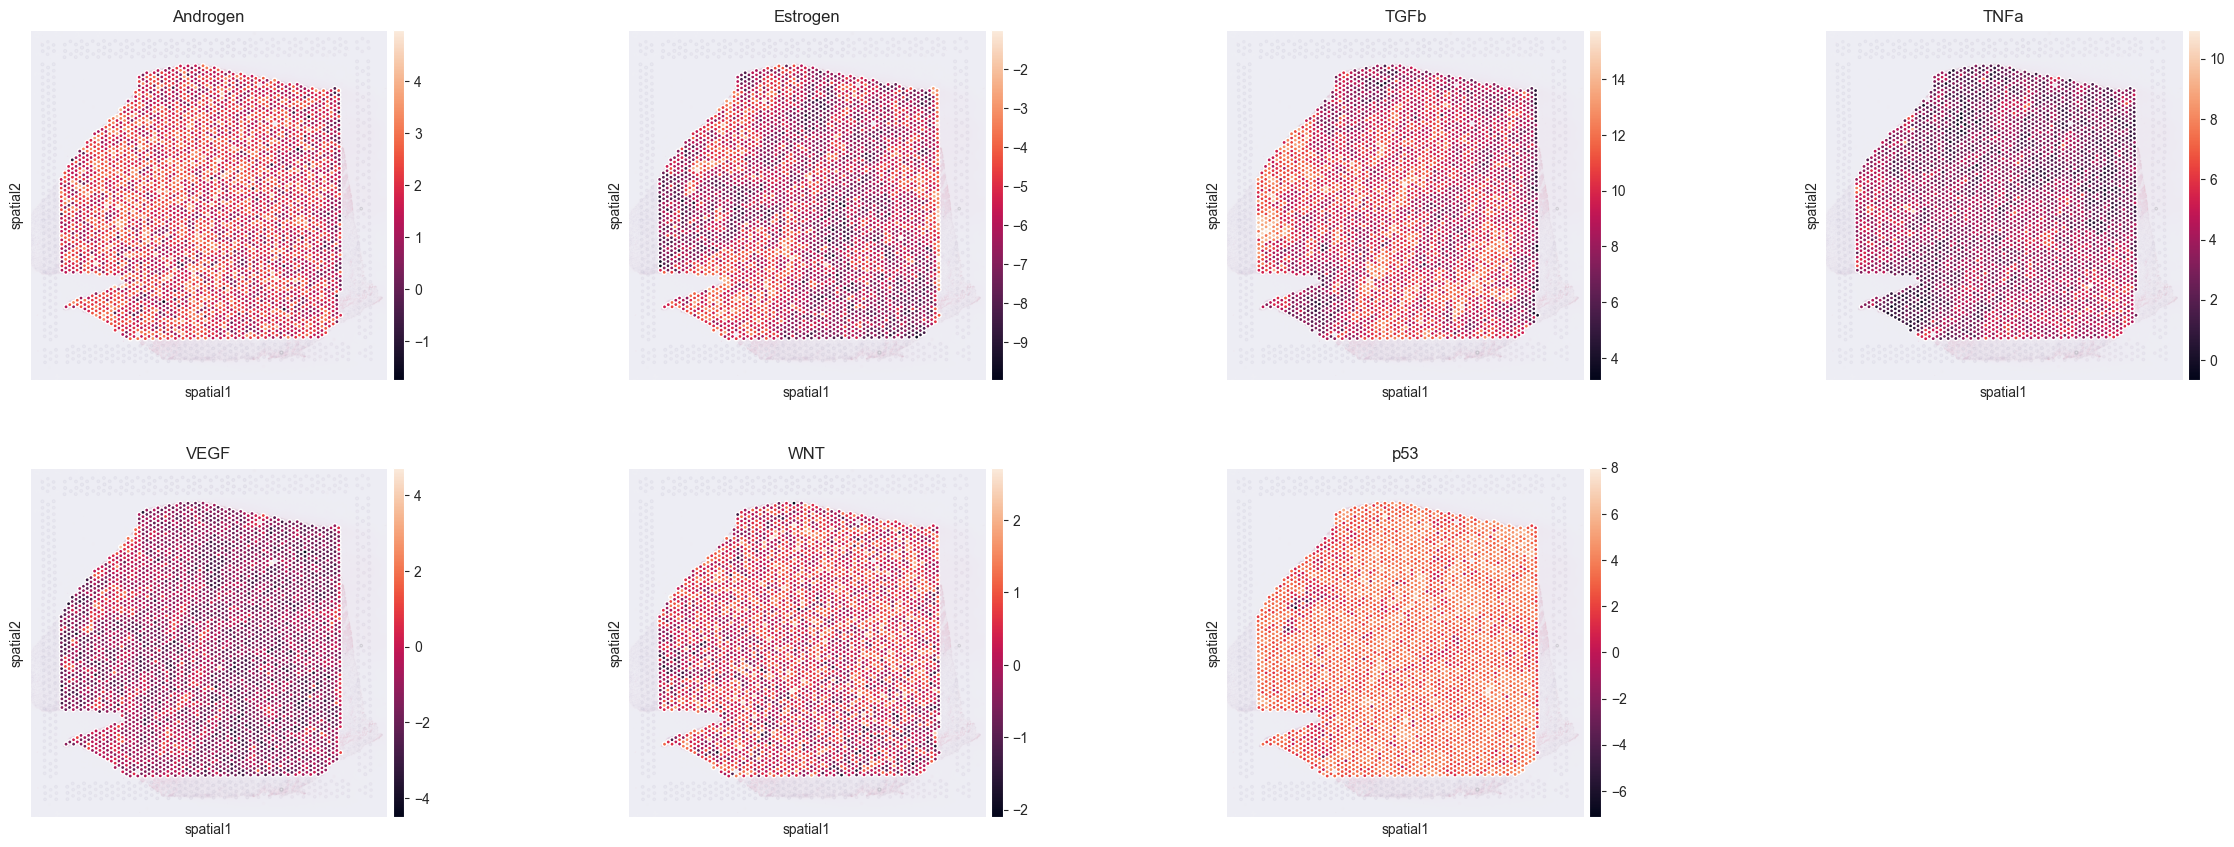

In [165]:
for library_id in score.obs["sample"].unique():
    adata_subset = score[score.obs["sample"] == library_id]
    sq.pl.spatial_scatter(
        adata_subset,
        color=['Androgen', 'Estrogen', 'TGFb', 'TNFa', 'VEGF', 'WNT', 'p53'],
        palette='RdBu_r',
        size=1.5,
        img_alpha=.2
    )

### Format MISTy object

MISTy objects are stored as a [MuData](https://github.com/scverse/mudata) [Bredikhin et al., 2021] object with one modality per view.

The *intra* view is our target variable.

In [166]:
cell_assignments = adata.obs['celltype_niche'].astype(str)

In [167]:
np.unique(cell_assignments)

array(['ctniche_1', 'ctniche_2', 'ctniche_3', 'ctniche_4', 'ctniche_5',
       'ctniche_6', 'ctniche_7', 'ctniche_8', 'ctniche_9'], dtype=object)

In [193]:
import pandas as pd
import anndata as ad

one_hot = pd.get_dummies(cell_assignments)  # One-hot encoding matrix

adata_ct = ad.AnnData(
    X=one_hot.to_numpy(),
    obs=pd.DataFrame(
        {"cell_assignment": pd.Categorical(cell_assignments)},
        index=adata.obs_names,  # Cells as `.obs`
    ),
    var=pd.DataFrame(index=one_hot.columns),  # Cell types as `.var`
)

adata_ct.obsm["spatial"] = adata.obsm["spatial"]
adata_ct.uns["spatial"] = adata.uns["spatial"]

In [200]:
adata_ct

AnnData object with n_obs × n_vars = 4113 × 9
    obs: 'cell_assignment'
    uns: 'spatial'
    obsm: 'spatial'

In [201]:
misty = genericMistyData(
    intra=adata_ct,
    extra=score,
    cutoff=0.05,
    bandwidth=200,
    n_neighs=6
)
misty

/Users/niemeyfr/Library/Caches/pypoetry/virtualenvs/practical-10-EMFiay-A-py3.13/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:88: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/niemeyfr/Library/Caches/pypoetry/virtualenvs/practical-10-EMFiay-A-py3.13/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:88: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/niemeyfr/Library/Caches/pypoetry/virtualenvs/practical-10-EMFiay-A-py3.13/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:88: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/niemeyfr/Library/Caches/pypoetry/virtualenvs/practical-10-EMFiay-A-py3.13/lib/python3.13/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which

MuData object with n_obs × n_vars = 4113 × 33
  obs:	'cell_assignment'
  3 modalities
    intra:	4113 x 5
      obs:	'cell_assignment'
      obsm:	'spatial'
    juxta:	4113 x 14
      obsm:	'spatial'
      layers:	'weighted'
      obsp:	'spatial_connectivities'
    para:	4113 x 14
      obsm:	'spatial'
      layers:	'weighted'
      obsp:	'spatial_connectivities'

## Learn relationship with MISTy

Now that we have constructed the object, we can learn the relationships across views.

Reationships can be learned by different models (e.i. RandomForrest, LinearModel). The fastest is the Linear model which we will fit here for each target in the intra-view, using the juxta and para views as predictors.

In [202]:
misty(model=LinearModel, k_cv=10, seed=1337, bypass_intra=True, verbose=True)

Now learning: ctniche_1:   0%|          | 0/5 [00:00<?, ?it/s]/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120

By default the results are saved in the `misty` object because `inplace = True`.

The `misty` object does now contain two DataFrames:

- `target_metrics`
- `interactions`

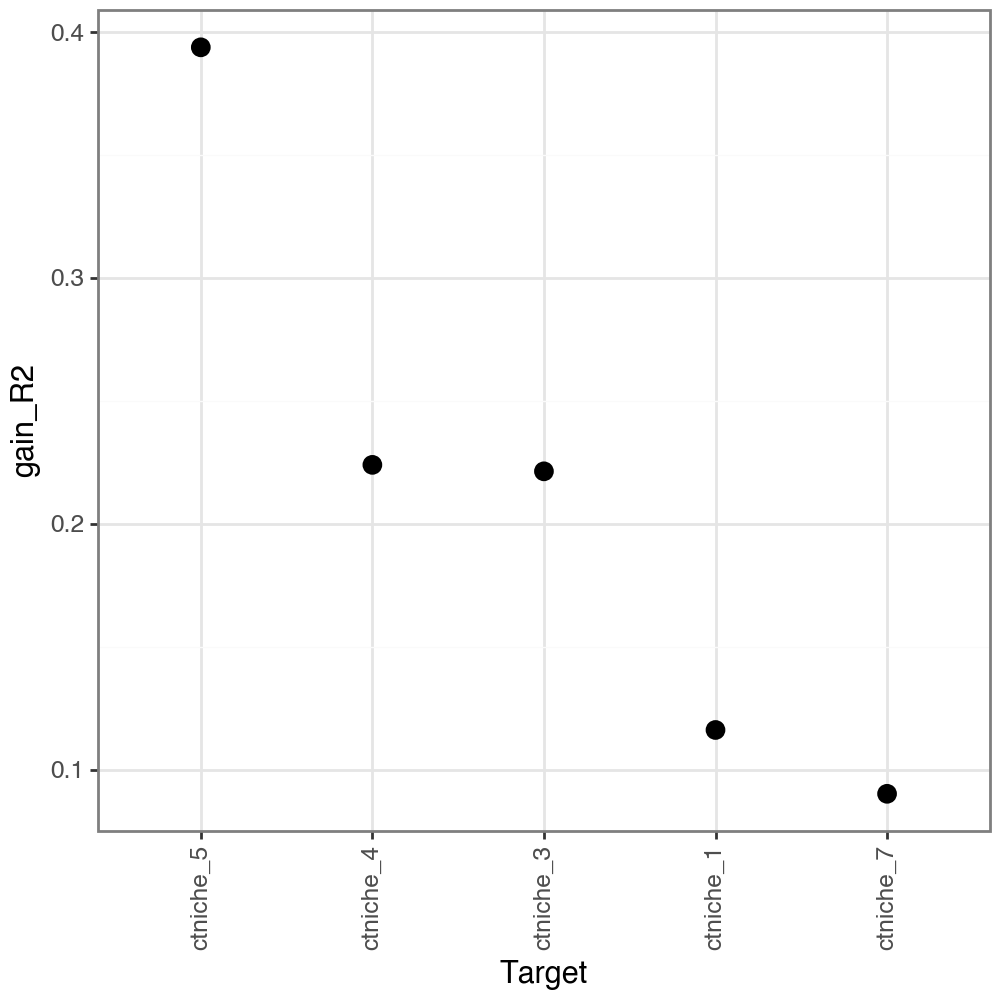

In [203]:
li.pl.target_metrics(misty, stat='gain_R2', return_fig=True)

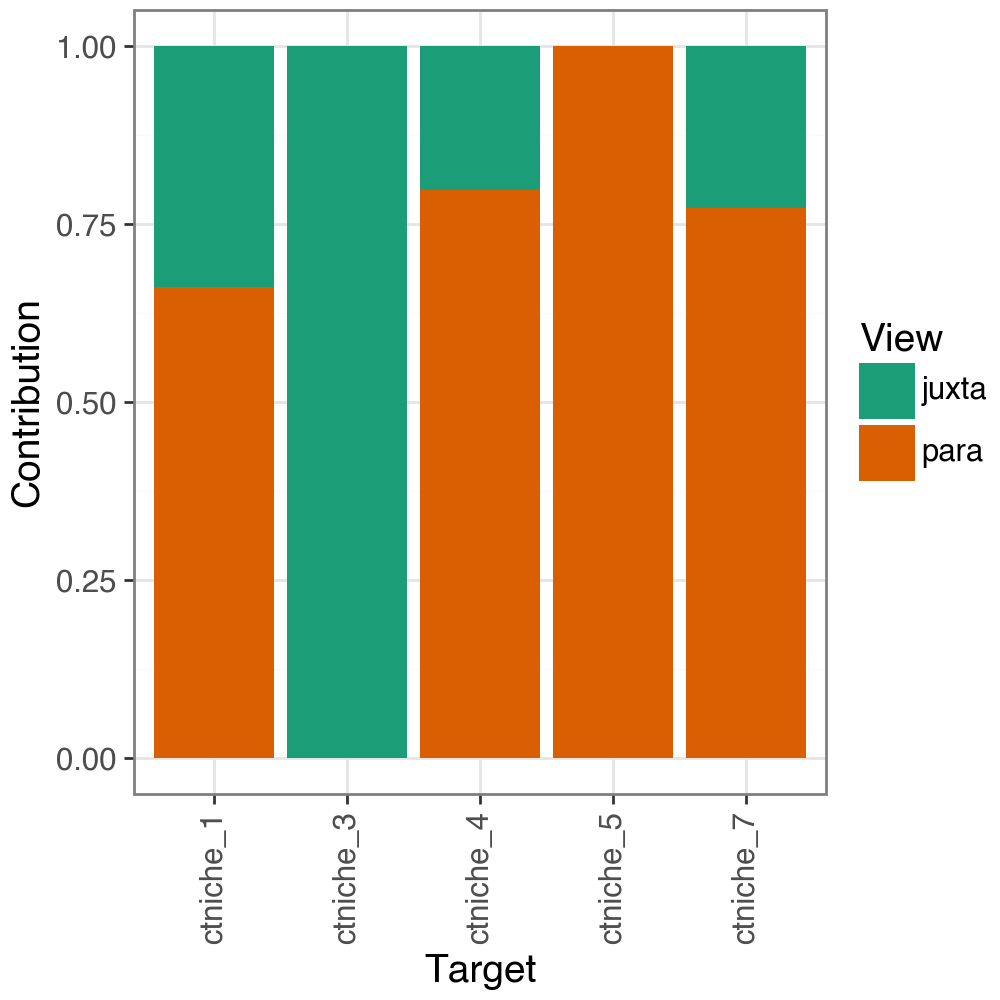

In [204]:
li.pl.contributions(misty, return_fig=True)

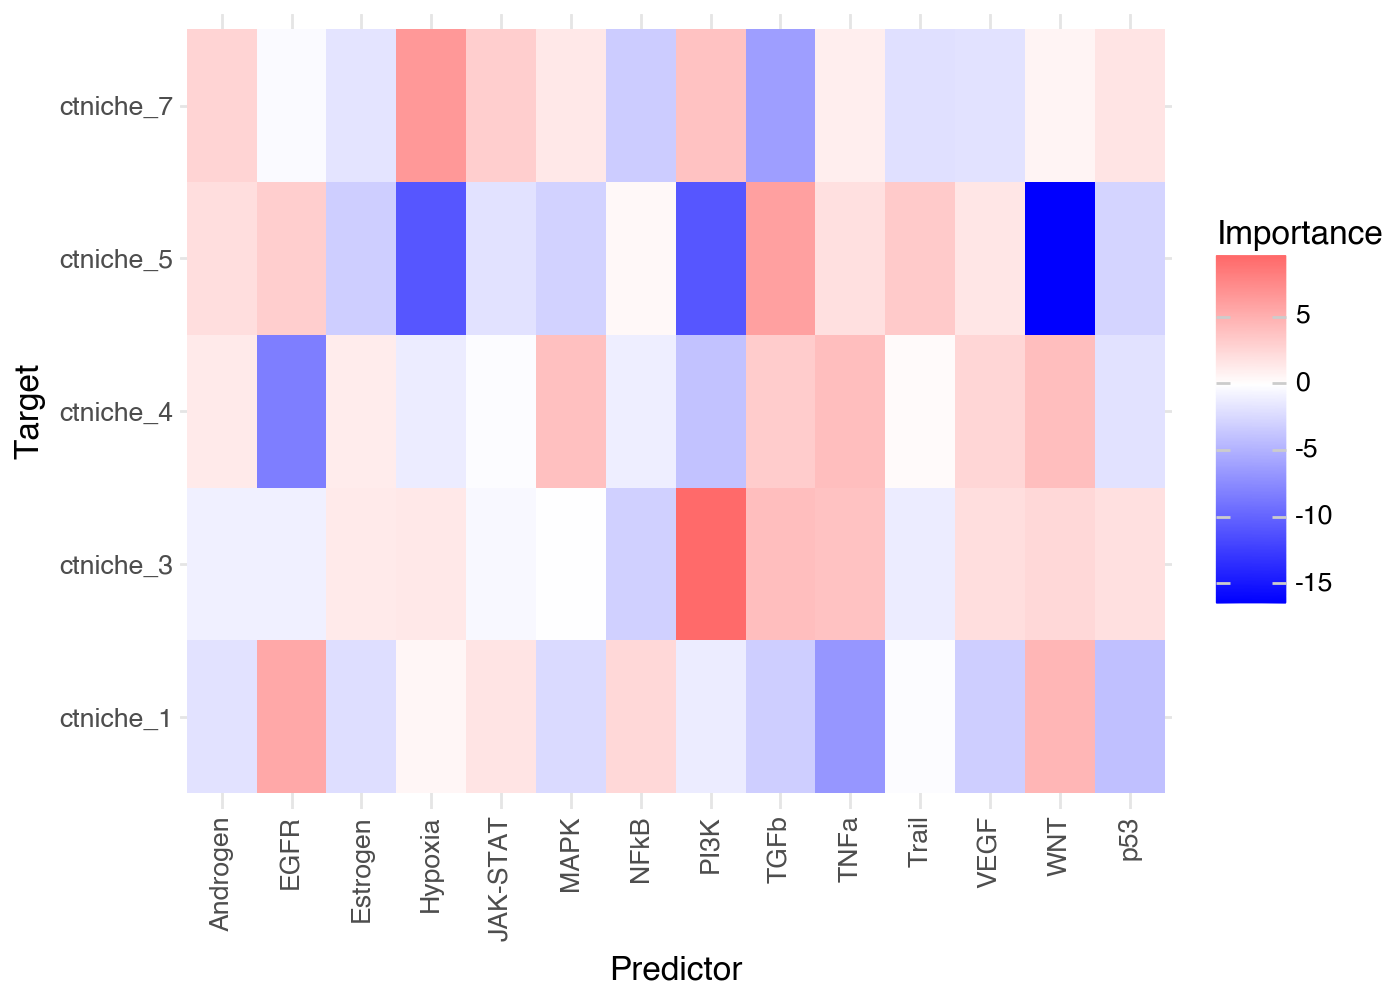

In [205]:
(
    li.pl.interactions(misty, view='juxta', return_fig=True, figure_size=(7,5)) +
    p9.scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0)
)

## Spatially-informed Bivariate Metrics

Here, we will demonstrate how to use the spatially-informed bivariate metrics to assess the spatial relationship between two variables, focussing on local bivariate similarity metrics. In contrast to other spatial Methods, including [Misty](https://liana-py.readthedocs.io/en/latest/notebooks/misty.html), focusing on local spatial relationships enables to pinpoint the exact location of spatial relationships, and to identify spatial relationships that might occur only in a specific sub-region of our samples.

Following the initial concept of LIANA, and inspired by [scHOT](https://www.nature.com/articles/s41592-020-0885-x), LIANA+ re-implements six local bivariate metrics, including scHOT’s (default) masked Spearman & SpatialDM’s local Moran’s R.

In the LIANA+ paper, two distinct metrics were tested for their ability to preserve biological information and identify local ligand-receptor relationships. The spatially-weighted Cosine similarity did best on this task. However, other scoring functions might be better suited for other tasks, e.g. Spatially-weighted Jaccard Similarity should be well suited for categorical data.

First, let's see again what methods are available.

In [206]:
li.mt.bivariate.show_functions()

name                                   metadata  \
0          pearson   weighted Pearson correlation coefficient   
1         spearman  weighted Spearman correlation coefficient   
2           cosine                 weighted Cosine similarity   
3          jaccard                weighted Jaccard similarity   
4          product                    simple weighted product   
5     norm_product                normalized weighted product   
6           morans                                  Moran's R   
7  masked_spearman     masked & weighted Spearman correlation   

                                           reference  
0                                               None  
1                                               None  
2                                               None  
3                                               None  
4  If vars are z-scaled = Lee's static (Lee 2021;...  
5                                               None  
6  Li, Z., Wang, T., Liu, P. and Huang, Y., 2022....  
7  Ghazanfar, S., Lin, Y., Su, X., Lin, D.M., Pat...

### Spatial Connectivity

The way that spatially-informed methods usually work is by making use of weights based on the proximity (or spatial connectivity) between spots/cells. These spatial connectivities are then used to calculate the metric of interest, e.g. Cosine similarity, in a spatially-informed manner.

The spatial weights in LIANA+ are by default defined as a family of radial kernels that use the inverse Euclidean distance between cells/spots to bind the weights between 0 and 1, with spots that are closest having the highest spatial connectivity to one another (1), while those that are thought to be too far to be in contact are assigned 0.

Key parameters of spatial_neighbors include:

- ``bandwidth`` controls the radius of the spatial connectivities where higher values will result in a broader area being considered (controls the radius relative to the coordinates stored in ``adata.obsm['spatial']``)
- ``cutoff`` controls the minimum value that will be considered to have a spatial relationship (anything lower than the ``cutoff`` is set to 0).
- ``kernel`` controls the distribution (shape) of the weights (‘gaussian’ by default)
- ``set_diag`` sets the diagonal (i.e. the weight for each spot to itself) to 1 if True. NOTE: Here we set it to True as we expect many cells to be neighbors of themselves within a visium spot

As choosing an optimal bandwidith can be tricky, we provide the query_bandwidth function which uses a set of coordinates to provide an estimate of how many cell or spot neighbors are being considered for each spot over a range of bandwidths

As choosing an optimal bandwidith can be tricky, we can use the ``query_bandwidth`` function, which uses a set of coordinates to provide an estimate of how many cell or spot neighbors are being considered for each spot over a range of bandwidths.

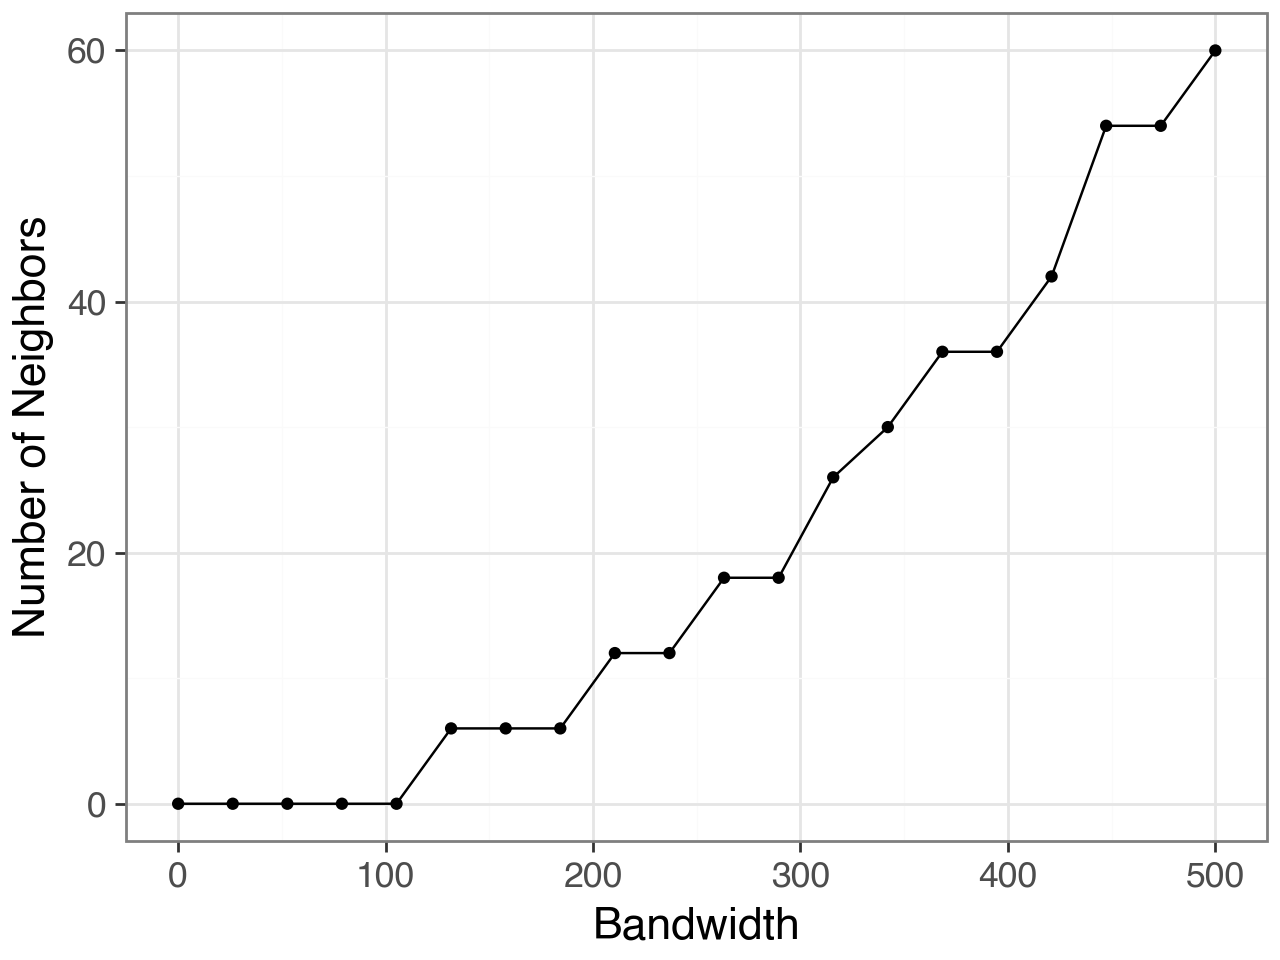

In [207]:
plot, _ = li.ut.query_bandwidth(coordinates=adata.obsm['spatial'], start=0, end=500, interval_n=20)
plot

Here, we can see that a bandwidth of 150-200 (pixels) roughly includes 6 neighbours i.e. the first ring of neighbours in the hexagonal grid of 10x Visium. So, we will build the spatial graph with a bandwidth of 200.

In [208]:
li.ut.spatial_neighbors(adata, bandwidth=200, cutoff=0.1, kernel='gaussian', set_diag=True)

Let’s visualize the spatial weights for a single spot to all other spots in the dataset:

/Users/niemeyfr/Library/Caches/pypoetry/virtualenvs/practical-10-EMFiay-A-py3.13/lib/python3.13/site-packages/liana/plotting/_connectivity_plot.py:38: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.


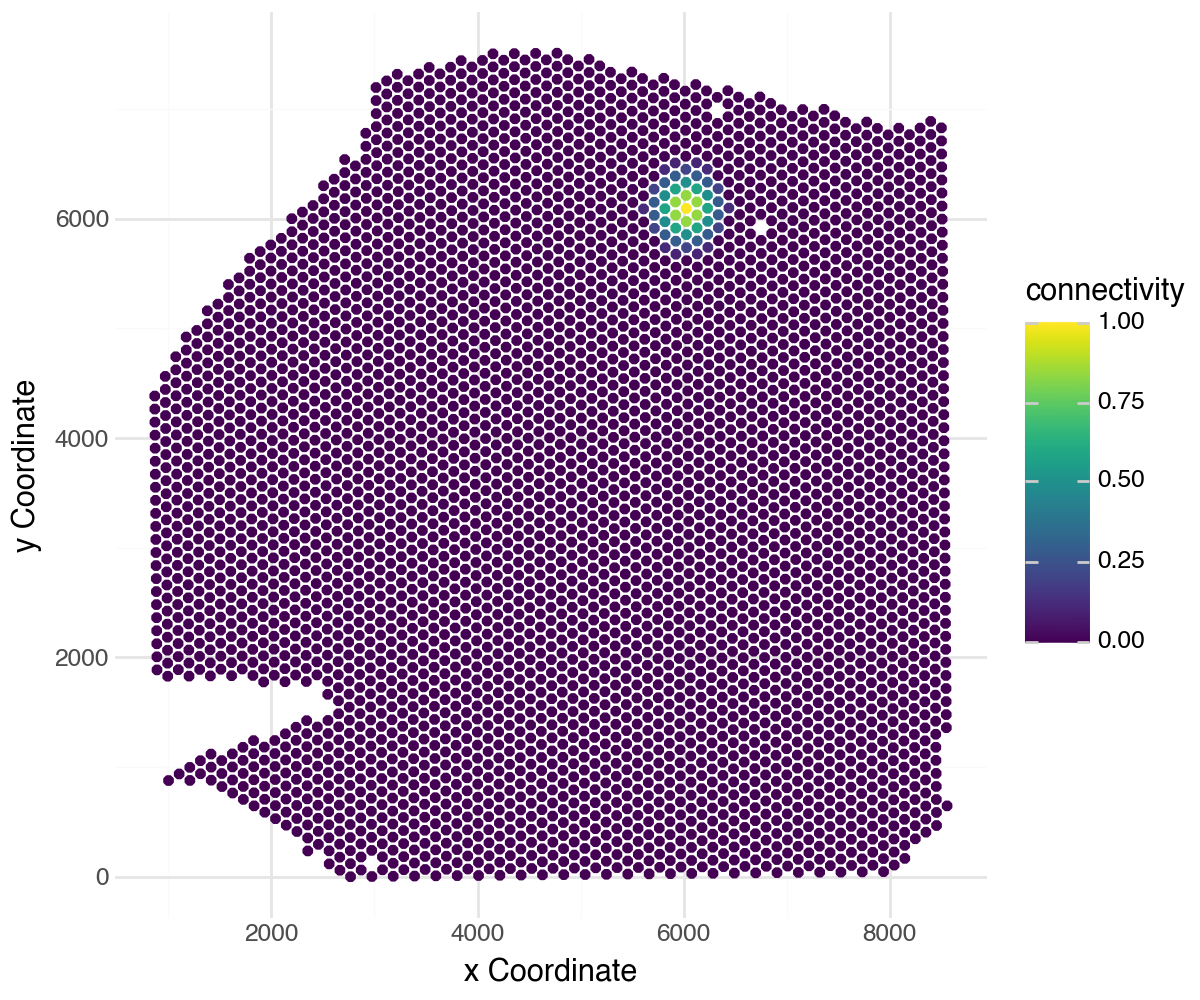

In [209]:
li.pl.connectivity(adata, idx=0, size=1.3, figure_size=(6, 5))

The basics are covered now, let's see how these scores look for potential ligand-receptor interactions on our 10X Visium Slide. Note that LIANA+ will take the presence of heteromeric complexes into account at the individual spot-level!

In [210]:
lrdata = li.mt.bivariate(adata,
                resource_name='consensus', # NOTE: uses HUMAN gene symbols!
                local_name='cosine', # Name of the function
                global_name="morans", # Name global function
                n_perms=100, # Number of permutations to calculate a p-value
                mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
                add_categories=True, # Whether to add local categories to the results
                nz_prop=0.2, # Minimum expr. proportion for ligands/receptors and their subunits
                use_raw=False,
                verbose=True
                )

Using `.X`!
/Users/niemeyfr/Library/Caches/pypoetry/virtualenvs/practical-10-EMFiay-A-py3.13/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:88: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
Using resource `consensus`.
100%|██████████| 100/100 [00:05<00:00, 19.55it/s]


### Global Summaries

In addition to the local bivariate scores, we can also get the “global” scores for each pair of variables, which we can choose the best pairs of variables to visualize:

In [211]:
lrdata.var.sort_values("mean", ascending=False).head(3)

ligand receptor  ligand_means  ligand_props  receptor_means  \
interaction                                                                 
TIMP1^CD63     TIMP1     CD63      8.552189      0.996839        8.042492   
LGALS1^ITGB1  LGALS1    ITGB1      9.872605      0.997326        6.837533   
LUM^ITGB1        LUM    ITGB1      8.979712      0.996353        6.837533   

              receptor_props    morans  morans_pvals      mean       std  
interaction                                                               
TIMP1^CD63          0.994165  0.096028           0.0  0.977192  0.029781  
LGALS1^ITGB1        0.988330  0.051698           0.0  0.973274  0.045510  
LUM^ITGB1           0.988330  0.038659           0.0  0.959823  0.039786

In [212]:
lrdata.var.sort_values("std", ascending=False).head(3)

ligand     receptor  ligand_means  ligand_props  \
interaction                                                        
S100A1^RYR2      S100A1         RYR2      1.884583      0.572332   
LPL^VLDLR           LPL        VLDLR      2.150974      0.609531   
VTN^ITGAV_ITGB5     VTN  ITGAV_ITGB5      1.156415      0.395089   

                 receptor_means  receptor_props    morans  morans_pvals  \
interaction                                                               
S100A1^RYR2            1.163836        0.406516  0.234713           0.0   
LPL^VLDLR              1.646962        0.540725  0.178286           0.0   
VTN^ITGAV_ITGB5        3.007067        0.814977  0.113657           0.0   

                     mean       std  
interaction                          
S100A1^RYR2      0.467636  0.260282  
LPL^VLDLR        0.544030  0.235395  
VTN^ITGAV_ITGB5  0.521604  0.231530

We can also use global bivariate Moran’s R (or [Lee’s statistic](https://onlinelibrary.wiley.com/doi/abs/10.1111/gean.12106)) - an extension of univariate Moran’s I, as proposed by [Anselin 2019](https://onlinelibrary.wiley.com/doi/full/10.1111/gean.12164) and [Lee and Li, 2019](https://onlinelibrary.wiley.com/doi/abs/10.1111/gean.12106); implemented in SEAGAL and SpatialDM.

Bivariate Moran’s R values near zero imply spatial independence, while positive or negative values reflect spatial co-clustering or spatial cross-dispersion, respectively.

In [213]:
lrdata.var.sort_values("morans", ascending=False).head()

ligand receptor  ligand_means  ligand_props  receptor_means  \
interaction                                                                    
APOE^LRP1          APOE     LRP1      3.370081      0.752006        5.429177   
SERPING1^LRP1  SERPING1     LRP1      4.808900      0.931437        5.429177   
MDK^LRP1            MDK     LRP1      3.152532      0.789691        5.429177   
S100A1^RYR2      S100A1     RYR2      1.884583      0.572332        1.163836   
C3^LRP1              C3     LRP1      1.544280      0.470460        5.429177   

               receptor_props    morans  morans_pvals      mean       std  
interaction                                                                
APOE^LRP1            0.956236  0.304565           0.0  0.792123  0.151093  
SERPING1^LRP1        0.956236  0.264367           0.0  0.894293  0.098997  
MDK^LRP1             0.956236  0.236053           0.0  0.815337  0.134158  
S100A1^RYR2          0.406516  0.234713           0.0  0.467636  0.260282  
C3^LRP1              0.956236  0.233991           0.0  0.620223  0.184270

From these Global summaries, we see that the average Cosine similarity largely represents coverage - e.g. TIMP1 & CD63 is ubiquitously and uniformly distributed across the slide.

On the other hand, among most variable interactions and with with the highest global Morans R is e.g. VTN&ITGAV_ITGB5. This interaction is thus more likely to represent biological relationships, with distinct spatial clustering patterns.

So, let’s visualize both:

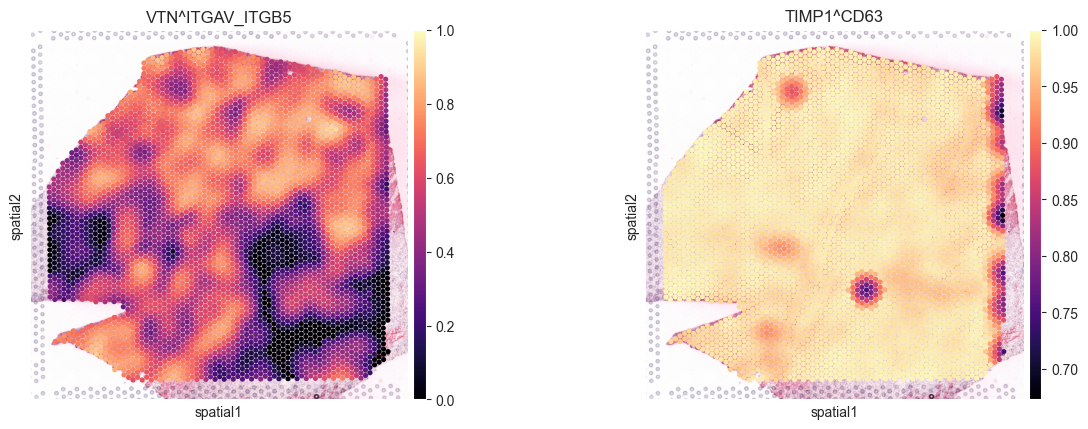

In [233]:
sc.pl.spatial(
    lrdata,
    color=['VTN^ITGAV_ITGB5', 'TIMP1^CD63'],
    size=1.5,
    vmax=1,
    cmap='magma',
)

As expected, we see that the TIMP1 & CD63 interaction is uniformly distributed across the slide, while VTN&ITGAV_ITGB5 shows a clear spatial pattern.

We can also see that this is the case when we look at the individual genes:

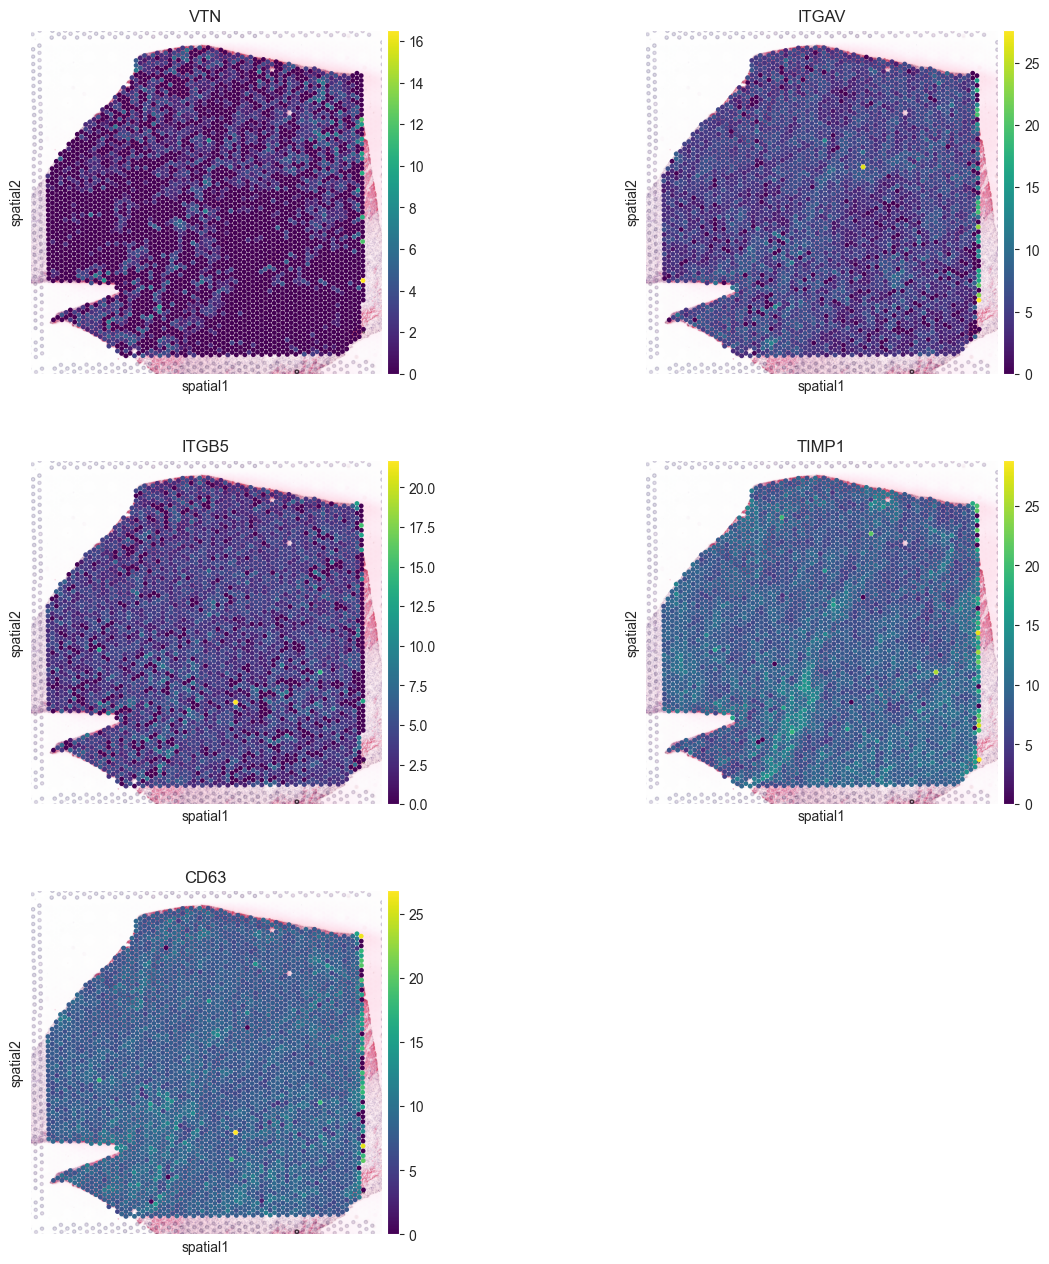

In [255]:
sc.pl.spatial(
    adata,
    color=['VTN', 'ITGAV', 'ITGB5', 'TIMP1', 'CD63'],
    size=1.5, ncols=2,
    cmap='viridis',
)

While Moran's R provides a sound summary of spatial clustering, it is limited to two variables at a time and is thus not a good fit for complex, or non-linear, spatial relationships between variables. This is where Misty can make more sense to use.

### Permutation-based p-values

In addition to the local scores, we also calculated permutation-based p-values based on a null distribution generated by shuffling the spot labels. Let’s see how these look for the two interactions from above:

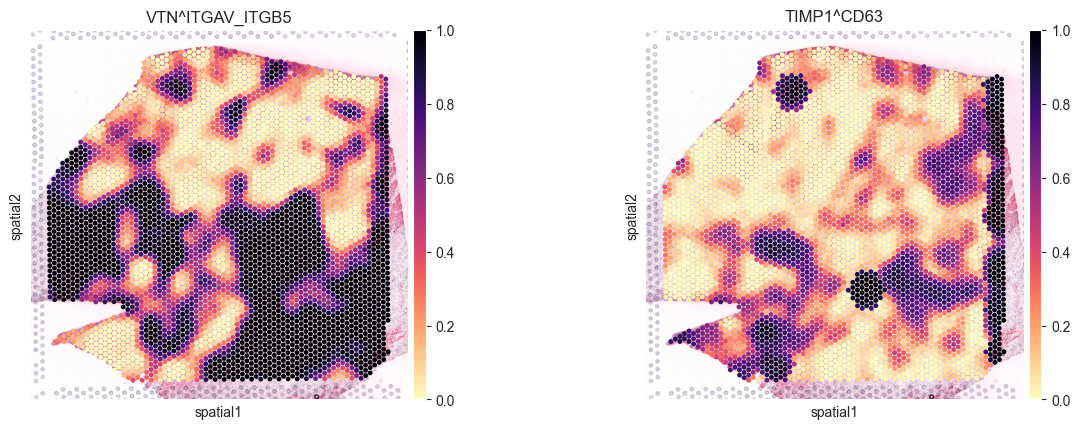

In [256]:
sc.pl.spatial(lrdata, layer='pvals', color=['VTN^ITGAV_ITGB5', 'TIMP1^CD63'], size=1.4, cmap="magma_r")

These largely agree with what we saw above for VTN&ITGAV_ITGB1 as appears to be specific to a certain region.

### Local Categories

Did you notice that we used ``mask_negatives`` as a parameter when first estimating the interaction? This essentially means that we mask interactions in which both members are negative (or lowly expressed) when calculating the p-values, i.e. such which occur at places in which both members of the interaction are highly expressed. The locations at which both members are highly-expressed is defined as follows:

For each interaction, we define the category of both x and y for each spot as follows:

$
\text{Category}_i(x) =
\begin{cases}
\text{positive} & \text{if } \displaystyle\sum_{i,j}^n w_{ij}\, x_j \;>\; 0, \\
\text{negative} & \text{if } \displaystyle\sum_{i,j}^n w_{ij}\, x_j \;<\; 0, \\
\text{neither}  & \text{otherwise},
\end{cases}
$

where $(w_{ij})$ are the spatial connectivity weights between spot $(i)$ and spot $(j)$.

Then for an interaction between variables \(x\) and \(y\), the combined category at spot \(i\) is defined such that:
- **high–high** (both positive) → category \(= 1\),
- **high–low** or **low–high** → category \(= -1\),
- **low–low** (both negative) → category \(= 0\).

When working with non-negative values (i.e. gene expression), the features will be z-scaled (across observations).

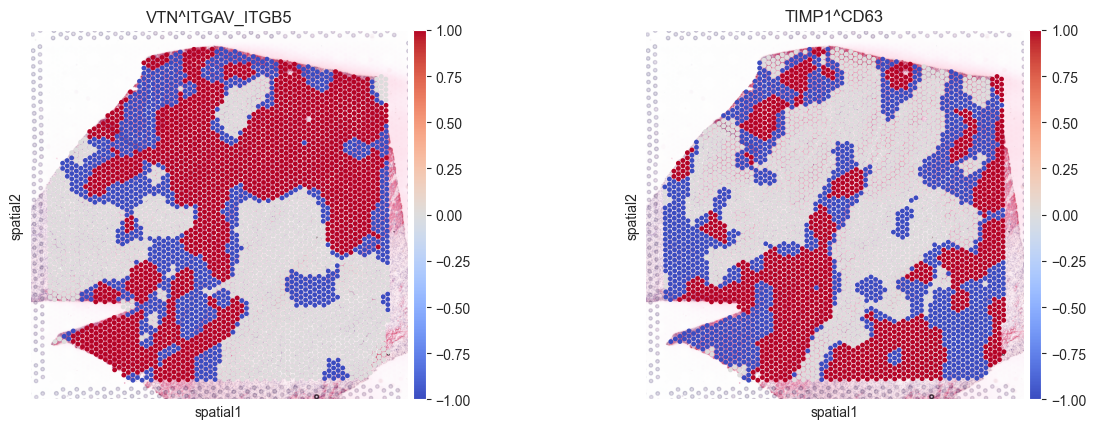

In [257]:
sc.pl.spatial(lrdata, layer='cats', color=['VTN^ITGAV_ITGB5', 'TIMP1^CD63'], size=1.4, cmap="coolwarm")

Here, we can distinguish areas in which the interaction between interaction members is positive (high-high) in Red (1), while interactions in which one is high the other is low or negative (High-low) are in Blue (-1). We also see that some interactions are neither, these are predominantly interactions in which both members are lowly-expressed (i.e. low-low); we see those in white (0).

When set to ``mask_negatives=False``, we also return interactions that are not between necessarily positive/high magnitude genes; when set to ``mask_negatives=True``, we mask interactions that are negative (low-low) or uncategorized; for both the p-values and the local scores.

# References

[1] Dimitrov D., Schäfer P.S.L, Farr E., Rodriguez Mier P., Lobentanzer S., Badia-i-Mompel P., Dugourd A., Tanevski J., Ramirez Flores R.O. and Saez-Rodriguez J. LIANA+ provides an all-in-one framework for cell–cell communication inference. Nat Cell Biol (2024). https://doi.org/10.1038/s41556-024-01469-w

[2] Li, Z., Wang, T., Liu, P. & Huang, Y. SpatialDM for rapid identification of spatially co-expressed ligand–receptor and revealing cell–cell communication patterns. Nat Commun 14, 3995 (2023).

[3] Bredikhin, D., Kats, I. & Stegle, O. MUON: multimodal omics analysis framework. Genome Biol 23, 42 (2022). https://doi.org/10.1186/s13059-021-02577-8

In the following chapter, we will work with the CellPhoneDB method from LIANA+.

## CellPhoneDB: non-spatial CCC

First, we will run CellPhoneDB as if we did not have any spatial information.